In [1]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from scipy import stats

import seaborn as sns
# sns.set_palette("deep")
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.facecolor':'white'})
plt.rcParams["figure.facecolor"] = "white"

%matplotlib inline

%load_ext autoreload
%autoreload 2

from analysis_helpers import load_data, savefig, heatmap_log_proba_plot, load_additional_data

from eye_plotting import AREA_ORDERING, AREA_ABBREV
from experiment.cre_line import match_cre_line, CRE_ORDERING

from saccade_config import *

In [2]:
cells = load_additional_data(LOADED_CLASSIFIED_CELLS_CSV, in_data_dir=False, index_col=0)
CRE_PLOT_KEY = "cre_abbrev"
print(f"There are {len(cells):,} total cells.")
cells.head()

There are 32,442 total cells.


,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_left,n_right,mean_left_response,mean_right_response,median_left_response,median_right_response,direction_selectivity,frac_left_significant,frac_right_significant,wilcoxon_signed_rank_p,ranksum_p_by_direction
specimen_id,,,,,,,,,,,,,,,,,,,
589170196,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 11), (510345479, 67), (510514474,...",0.0,0.148500,25.0,36.0,-0.005011,0.028588,-0.003895,-0.000737,1.425049,0.20,0.138889,0.378918,0.311603
517424547,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 109), (510345479, 68), (510514474...",0.0,0.849025,25.0,36.0,-0.008454,-0.002251,-0.013324,0.000459,-0.579440,0.20,0.166667,0.489899,0.472405
589170394,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 27), (510345479, 205), (510514474...",0.0,0.994925,25.0,36.0,-0.084782,-0.060959,-0.033635,0.006427,-0.163455,0.20,0.277778,0.245655,0.018225
589170745,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 6), (510345479, 206), (510514474,...",0.0,0.018600,25.0,36.0,0.133313,0.303742,-0.005347,0.017718,0.389949,0.24,0.194444,0.301768,0.713904
589170856,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 9), (510345479, 22), (510514474, 9))",0.0,0.231125,25.0,36.0,-0.013324,0.014109,-0.006405,0.009928,34.951378,0.24,0.222222,0.893064,0.012153


In [3]:
# Table of cre lines, abbreviations, and number of cells
df_cre_info = pd.DataFrame(index=CRE_ORDERING)
df_cre_info["cre_full"] = [match_cre_line(cre).get_full_cre_name() for cre in CRE_ORDERING]
df_cre_info["cre_abbreviation"] = CRE_ORDERING
df_cre_info["num_sessions"] = 0
df_cre_info["all_cells"] = [set() for _ in df_cre_info.index]
df_cre_info["all_mice_ids"] = [set() for _ in df_cre_info.index]

for data in load_data(tqdm_desc="Loading session information"):
    cre_line = match_cre_line(data)
    cre = str(cre_line)
    df_cre_info.at[cre, "num_sessions"] += 1
    df_cre_info.at[cre, "all_cells"].update(data["cell_specimen_ids"])
    df_cre_info.at[cre, "all_mice_ids"].add(data["metadata"]["specimen_name"])

df_cre_info["num_cells_total"] = df_cre_info["all_cells"].apply(len)
df_cre_info.drop("all_cells", axis=1, inplace=True)
df_cre_info["num_mice_total"] = df_cre_info["all_mice_ids"].apply(len)
df_cre_info.drop("all_mice_ids", axis=1, inplace=True)
df_cre_info["num_cells_analyzed"] = cells[CRE_PLOT_KEY].value_counts().reindex(df_cre_info.index)
df_cre_info.head(-1)

Loading session information:   0%|          | 0/818 [00:00<?, ?it/s]

,cre_full,cre_abbreviation,num_sessions,num_cells_total,num_mice_total,num_cells_analyzed
Emx1; Ai93,Emx1-IRES-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Emx1; Ai93,83,8866,17,5020
Slc17a7; Ai93,Slc17a7-IRES2-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Slc17a7; Ai93,124,8512,24,7707
Slc17a7; Ai94,Slc17a7-IRES2-Cre; Camk2a-tTA; Ai94(TITL-GCaMP6s),Slc17a7; Ai94,6,817,1,817
Cux2; Ai93,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,121,10181,32,6832
Rorb; Ai93,Rorb-IRES2-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Rorb; Ai93,61,4738,18,3485
Scnn1a; Ai93,Scnn1a-Tg3-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Scnn1a; Ai93,21,1513,6,935
Nr5a1; Ai93,Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Nr5a1; Ai93,71,2122,20,1353
Rbp4; Ai93,Rbp4-Cre_KL100; Camk2a-tTA; Ai93(TITL-GCaMP6f),Rbp4; Ai93,72,1649,21,1399
Fezf2; Ai148,Fezf2-CreER; Ai148(TIT2L-GC6f-ICL-tTA2),Fezf2; Ai148,25,1346,8,1338
Tlx3; Ai148,Tlx3-Cre_PL56; Ai148(TIT2L-GC6f-ICL-tTA2),Tlx3; Ai148,12,979,3,979


In [4]:
df_cre_info.sum()

cre_full              Emx1-IRES-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)S...
cre_abbreviation      Emx1; Ai93Slc17a7; Ai93Slc17a7; Ai94Cux2; Ai93...
num_sessions                                                        818
num_cells_total                                                   43316
num_mice_total                                                      205
num_cells_analyzed                                                32442
dtype: object

In [5]:
miura_sig = ((cells["wilcoxon_signed_rank_p"] < 5e-2) | (cells["ranksum_p_by_direction"] < 5e-2))
miura_sig.sum(), miura_sig.mean() * 100

(20629, 63.58732507243696)

In [6]:
cells["depth_trunc"] = 100 * (cells["depth"]/100).astype(int)
cells.at[cells["cre_line"] == "Scnn1a-Tg3-Cre", "depth_trunc"] = 200
cells.at[cells["cre_line"] == "Nr5a1-Cre", "depth_trunc"] = 200
cells.at[cells["cre_line"] == "Fezf2-CreER", "depth_trunc"] = 300
cells.at[cells["depth_trunc"] == 400, "depth_trunc"] = 300

depth_to_layer = {
    100: "2/3",
    200: "4",
    300: "5",
    500: "6",
}

cells["cortical_layer"] = cells["depth_trunc"].apply(lambda depth_trunc: depth_to_layer[depth_trunc])

In [7]:
miura_thresh = 5e-2 # 0.05
dir_thresh = 0.05

response_classification = cells["response_classification"]
cells["is_sr"] = (response_classification.abs() == 1)
is_ds = (cells["ranksum_p_by_direction"] < dir_thresh)
is_sr_ds = (cells["is_sr"]) & is_ds
cells["is_sr_ds"] = is_sr_ds
cells["is_sr_miura"] = ((cells["wilcoxon_signed_rank_p"] < miura_thresh) | (cells["ranksum_p_by_direction"] < miura_thresh))
cells["is_sr_ds_miura"] = cells["is_sr_miura"] & is_ds


# Compute preferred direction
larger_R_response = cells["mean_right_response"] > cells["mean_left_response"]
cells["preferred_direction"] = 0

# pref_dir_temporal = (
#     ((cells["response_classification"] == 1) & larger_R_response)
#      | ((cells["response_classification"] == -1) & ~larger_R_response)
# )

# pref_dir_nasal = (
#     ((cells["response_classification"] == 1) & ~larger_R_response)
#      | ((cells["response_classification"] == -1) & larger_R_response)
# )

# ONLY CONSIDER ENHANCED RESPONSES
pref_dir_temporal = (cells["response_classification"] == 1) & larger_R_response
pref_dir_nasal = (cells["response_classification"] == 1) & ~larger_R_response

cells.loc[is_sr_ds & pref_dir_temporal, "preferred_direction"] = 1
cells.loc[is_sr_ds & pref_dir_nasal, "preferred_direction"] = -1

cells.loc[cells["is_sr_miura"] & is_ds & pref_dir_temporal, "preferred_direction_miura"] = 1
cells.loc[cells["is_sr_miura"] & is_ds & pref_dir_nasal, "preferred_direction_miura"] = -1

cells.head()

,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_left,n_right,...,wilcoxon_signed_rank_p,ranksum_p_by_direction,depth_trunc,cortical_layer,is_sr,is_sr_ds,is_sr_miura,is_sr_ds_miura,preferred_direction,preferred_direction_miura
specimen_id,,,,,,,,,,,,,,,,,,,,,
589170196,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 11), (510345479, 67), (510514474,...",0.0,0.148500,25.0,36.0,...,0.378918,0.311603,100,2/3,False,False,False,False,0,NaN
517424547,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 109), (510345479, 68), (510514474...",0.0,0.849025,25.0,36.0,...,0.489899,0.472405,100,2/3,False,False,False,False,0,NaN
589170394,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 27), (510345479, 205), (510514474...",0.0,0.994925,25.0,36.0,...,0.245655,0.018225,100,2/3,False,False,True,True,0,NaN
589170745,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 6), (510345479, 206), (510514474,...",0.0,0.018600,25.0,36.0,...,0.301768,0.713904,100,2/3,False,False,False,False,0,NaN
589170856,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 9), (510345479, 22), (510514474, 9))",0.0,0.231125,25.0,36.0,...,0.893064,0.012153,100,2/3,False,False,True,True,0,NaN


In [8]:
n_sr = cells["is_sr"].sum()
n_sr_e = (cells["response_classification"] == 1).sum()
n_sr_s = (cells["response_classification"] == -1).sum()
n_sr_ds_T = ((cells["response_classification"] == 1) & (cells["preferred_direction"] == 1)).sum()
n_sr_ds_N = ((cells["response_classification"] == 1) & (cells["preferred_direction"] == -1)).sum()
n_sr_not_ds = ((cells["response_classification"] == 1) & (cells["preferred_direction"] == 0)).sum()
print(f"{n_sr:,} out of {len(cells):,} ({n_sr/len(cells)*100:.1f}%) cells were saccade-responsive, with {n_sr_e:,} ({n_sr_e/n_sr*100:.1f}%) having an enhanced response and {n_sr_s:,} ({n_sr_s/n_sr*100:.1f}%) having a suppressed response.")
print(f"out of {n_sr_e:,} saccade-responsive cells with an enhanced response, {n_sr_ds_T:,} ({n_sr_ds_T/n_sr_e*100:.1f}%) preferred temporal saccades, {n_sr_ds_N:,} ({n_sr_ds_N/n_sr_e*100:.1f}%) preferred nasal saccades, and {n_sr_not_ds:,} ({n_sr_not_ds/n_sr_e*100:.1f}%) were not direction-selective.")

3,071 out of 32,442 (9.5%) cells were saccade-responsive, with 2,696 (87.8%) having an enhanced response and 375 (12.2%) having a suppressed response.
out of 2,696 saccade-responsive cells with an enhanced response, 1,467 (54.4%) preferred temporal saccades, 318 (11.8%) preferred nasal saccades, and 911 (33.8%) were not direction-selective.


([<matplotlib.patches.Wedge at 0x7f8848b60a90>,
 [Text(1.0517159418503321, 0.3223252668623246, 'SR'),
  Text(-1.0517159343057645, -0.3223252914795128, 'Not SR')],
 [Text(0.573663241009272, 0.1758137819249043, '9.5%'),
  Text(-0.5736632368940533, -0.1758137953524615, '90.5%')])

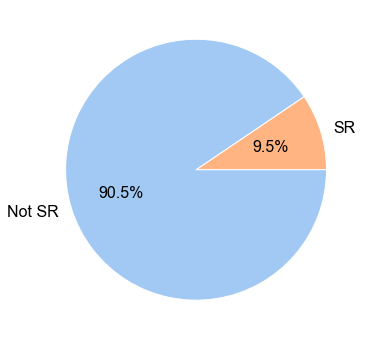

In [9]:
pie_data = [
    (cells["is_sr"]).sum(),
    (~cells["is_sr"]).sum(),
]
pie_labels = ["SR", "Not SR"]
plt.figure(figsize=(6, 6), facecolor="white")
colors = reversed(sns.color_palette("pastel")[:len(pie_data)]) # Reversed so it matches coloring below lol
plt.pie(pie_data, labels=pie_labels, colors=colors, autopct="%.1f%%", textprops=dict(fontsize=16, color="black"))

In [10]:
label_none = "No response"
label_enhanced = "Enhanced: No DS"
label_suppressed = "Suppressed"
label_nasal = "Enhanced: Nasal"
label_temporal = "Enhanced: Temporal"

cells["sr_label"] = label_none
cells.at[(cells["response_classification"] == 1) & ~(cells["is_sr_ds"]), "sr_label"] = label_enhanced
cells.at[(cells["response_classification"] == -1), "sr_label"] = label_suppressed
cells.at[(cells["is_sr"]) & (cells["preferred_direction"] == -1), "sr_label"] = label_nasal
cells.at[(cells["is_sr"]) & (cells["preferred_direction"] == 1), "sr_label"] = label_temporal

cells["sr_label_miura"] = label_none
cells.at[(cells["is_sr_miura"]) & ~(cells["is_sr_ds_miura"]), "sr_label_miura"] = "SR"
cells.at[(cells["is_sr_miura"]) & (cells["preferred_direction_miura"] == -1), "sr_label_miura"] = label_nasal
cells.at[(cells["is_sr_miura"]) & (cells["preferred_direction_miura"] == 1), "sr_label_miura"] = label_temporal

print(cells["sr_label"].value_counts())
print()
print(cells["sr_label_miura"].value_counts())

SR_LABELS = [
    (label_none, "gray"),
    (label_suppressed, "purple"),
    (label_enhanced, "green"),
    (label_nasal, "b"),
    (label_temporal, "r"),
]

No response           29371
Enhanced: Temporal     1467
Enhanced: No DS         911
Suppressed              375
Enhanced: Nasal         318
Name: sr_label, dtype: int64

No response           24961
SR                     5696
Enhanced: Temporal     1467
Enhanced: Nasal         318
Name: sr_label_miura, dtype: int64


In [11]:
metrics = load_additional_data("metrics.csv")
metrics.drop([c for c in metrics.columns if "Unnamed" in c], axis=1, inplace=True)

dsi_df = load_additional_data("dsi.csv")
metrics = metrics.merge(dsi_df[["cell_specimen_id", "DSI_pref_tf"]], on="cell_specimen_id")
metrics.set_index("cell_specimen_id", inplace=True)
# metrics.head()

cells_and_metrics = cells.join(metrics, how="inner")
print(f"{len(cells_and_metrics):,}/{len(cells):,} cells have associated metrics")

cells_and_metrics.head()

/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (4,8,12,16,20,32,53,69) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


21,612/32,442 cells have associated metrics


,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_left,n_right,...,run_stat_dg,responsive_rundg,run_corr_mean,run_corr_A_lw,run_corr_B_lw,run_corr_C_lw,responsive_run,dg_all_RidgeRegress_CC,cluster_id,DSI_pref_tf
589170196,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 11), (510345479, 67), (510514474,...",0.0,0.148500,25.0,36.0,...,NaN,False,0.042226,0.071127,0.042226,0.030272,True,0.060153,12.0,0.527993
517424547,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 109), (510345479, 68), (510514474...",0.0,0.849025,25.0,36.0,...,NaN,False,0.055001,-0.002882,0.055001,0.023352,True,0.190018,14.0,1.000000
589170394,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 27), (510345479, 205), (510514474...",0.0,0.994925,25.0,36.0,...,NaN,False,0.010461,-0.016332,0.010461,0.007804,True,0.007472,8.0,0.878755
589170745,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 6), (510345479, 206), (510514474,...",0.0,0.018600,25.0,36.0,...,NaN,False,-0.018242,0.014539,-0.018242,0.025295,True,0.138445,12.0,0.796653
589170856,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 9), (510345479, 22), (510514474, 9))",0.0,0.231125,25.0,36.0,...,NaN,False,0.159348,-0.005516,0.159348,-0.014270,True,0.238036,8.0,0.639498


# Visualize how many cells respond

In [12]:
df_rows = []

for cre_line in CRE_ORDERING:
    for targeted_structure in AREA_ORDERING:
        df = cells[(cells[CRE_PLOT_KEY] == cre_line) & (cells["targeted_structure"] == targeted_structure)]
        n_cells = len(df)

        if n_cells > 0:
            df_responsive = df[df["is_sr"]]
            n_responsive = len(df_responsive)

            df_responsive_miura = df[df["is_sr_miura"]]
            n_responsive_miura = len(df_responsive_miura)

            df_rows.append({
                CRE_PLOT_KEY: cre_line,
                "targeted_structure": targeted_structure,
                "n_cells": n_cells,
                "n_cells_responsive": n_responsive,
                "frac_responsive": n_responsive/n_cells,
                "n_cells_responsive_miura": n_responsive_miura,
                "frac_responsive_miura": n_responsive_miura/n_cells,
            })

responses_by_cre_and_area = pd.DataFrame(df_rows)
responses_by_cre_and_area.head()

,cre_abbrev,targeted_structure,n_cells,n_cells_responsive,frac_responsive,n_cells_responsive_miura,frac_responsive_miura
0,Emx1; Ai93,VISp,646,20,0.030960,266,0.411765
1,Emx1; Ai93,VISl,886,97,0.109481,633,0.714447
2,Emx1; Ai93,VISal,772,61,0.079016,543,0.703368
3,Emx1; Ai93,VISpm,274,13,0.047445,111,0.405109
4,Emx1; Ai93,VISam,363,80,0.220386,209,0.575758


In [13]:
df = responses_by_cre_and_area.pivot(CRE_PLOT_KEY, "targeted_structure", "n_cells")
df = df.reindex(CRE_ORDERING, axis=0).reindex(AREA_ORDERING, axis=1)#.reindex(columns=[AREA_ABBREV[a] for a in AREA_ORDERING])
df.columns = [AREA_ABBREV[a] for a in df.columns]
df.head()

,V1,LM,AL,PM,AM,RL
cre_abbrev,,,,,,
Emx1; Ai93,646.0,886.0,772.0,274.0,363.0,2079.0
Slc17a7; Ai93,3671.0,2033.0,338.0,1293.0,235.0,137.0
Slc17a7; Ai94,817.0,NaN,NaN,NaN,NaN,NaN
Cux2; Ai93,1504.0,1311.0,1046.0,1038.0,916.0,1017.0
Rorb; Ai93,849.0,683.0,299.0,292.0,385.0,977.0


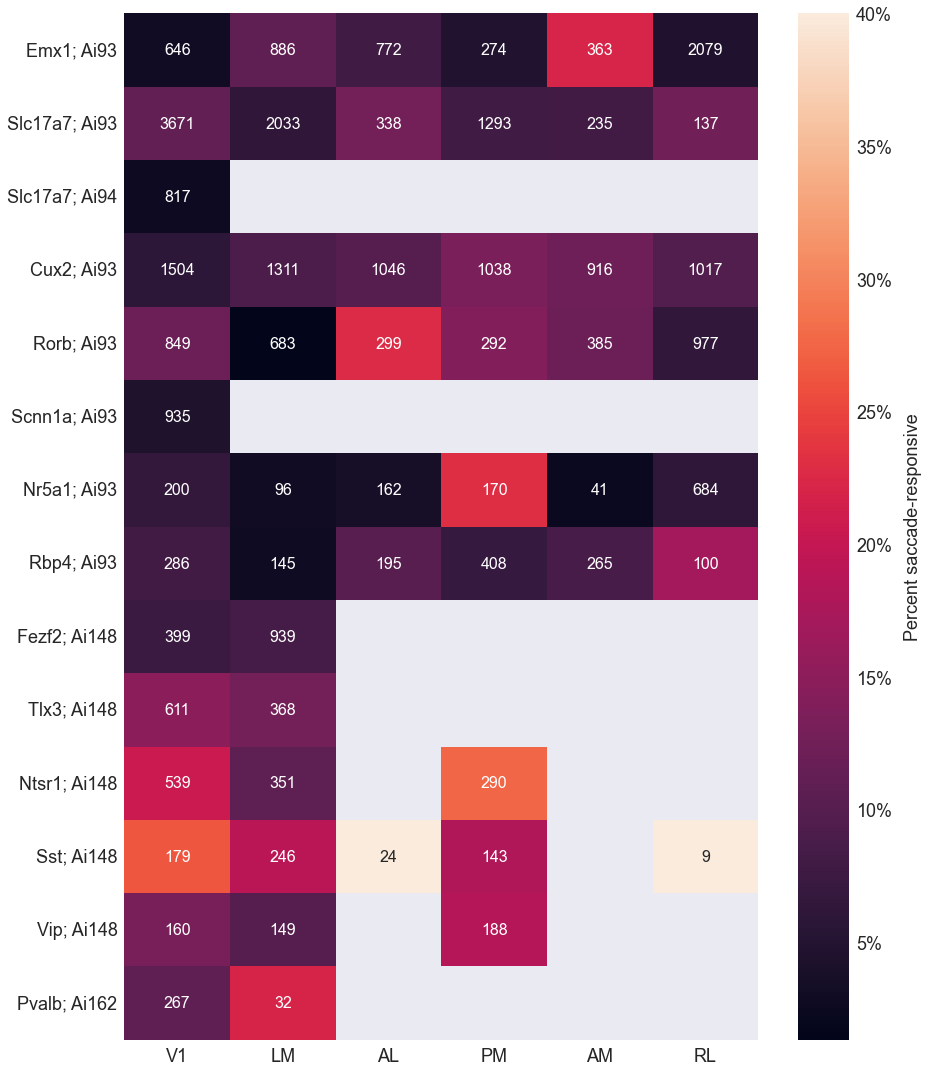

In [14]:
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(figsize=(13, 15), facecolor="w")
    frac_responsive = responses_by_cre_and_area.pivot(CRE_PLOT_KEY, "targeted_structure", "frac_responsive")
    n_cells = responses_by_cre_and_area.pivot(CRE_PLOT_KEY, "targeted_structure", "n_cells")

    frac_responsive = frac_responsive.reindex(CRE_ORDERING, axis=0).reindex(AREA_ORDERING, axis=1)
    # frac_responsive.index = [CRE_TO_REPORTER[x] for x in frac_responsive.index]
    # frac_responsive.columns = [AREA_ABBREV[x] for x in frac_responsive.columns] # Area abbreviations
    
    n_cells = n_cells.reindex(CRE_ORDERING, axis=0).reindex(AREA_ORDERING, axis=1)
    # n_cells.index = [CRE_TO_REPORTER[x] for x in frac_responsive.index]
    # n_cells.columns = [AREA_ABBREV[x] for x in n_cells.index] # Area abbreviations

    # sns.heatmap(frac_responsive, annot=n_cells, fmt=".0f", cmap="magma", ax=axs[0], vmin=0, vmax=1)
    # sns.heatmap(frac_responsive_miura, annot=n_cells, fmt=".0f", cmap="magma", ax=axs[1], vmin=0, vmax=1)
    sns.heatmap(frac_responsive, annot=n_cells, fmt=".0f", ax=ax, annot_kws=dict(fontsize=16), vmax=0.4)
    # sns.heatmap(frac_responsive_miura, annot=n_cells, fmt=".0f", ax=axs[1], annot_kws=dict(fontsize=16))
    plt.setp(ax, xlabel="", ylabel="")
    ax.set_xticklabels([AREA_ABBREV[a] for a in AREA_ORDERING], fontsize=18)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    # ax.set_yticklabels(CRE_LINE_REPORTER_ORDERING, fontsize=18, rotation=0)
    # ax.set_title("Fraction of SR cells by cre and region (n = total no. imaged cells)", fontsize=22)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)
    cbar.set_ticks(cbar.get_ticks())
    cbar.set_ticklabels([f"{tick*100:.0f}%" for tick in cbar.get_ticks()])
    cbar.set_label("Percent saccade-responsive", fontsize=18, labelpad=12, va="top") # , rotation=270, va="bottom"

    # axs[1].set_title("Significance method: Miura", fontsize=18)
    fig.tight_layout()
    savefig(fig, "fraction_responsive_heatmap.png") 

cre_abbrev  is_sr
Cux2; Ai93  False    6169
            True      663
Emx1; Ai93  False    4654
            True      366
Name: is_sr, dtype: int64


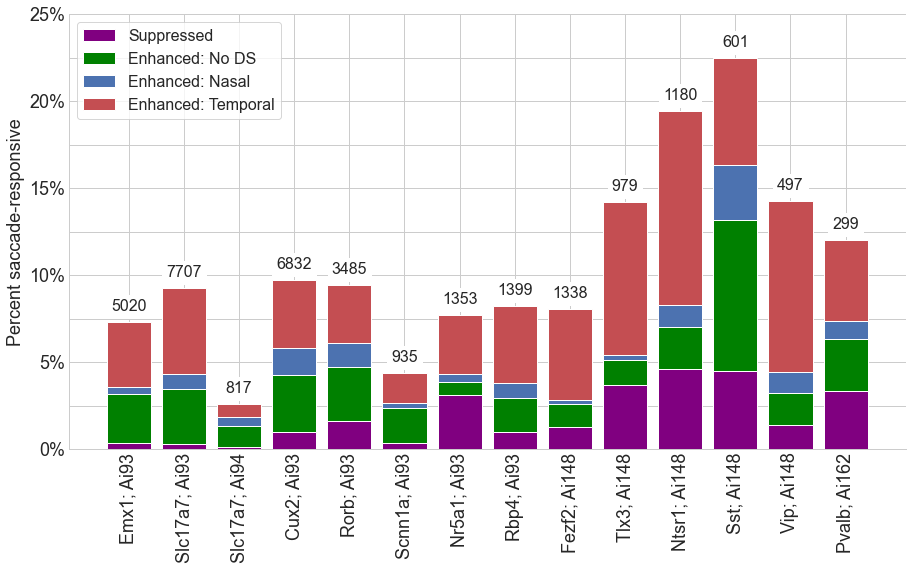

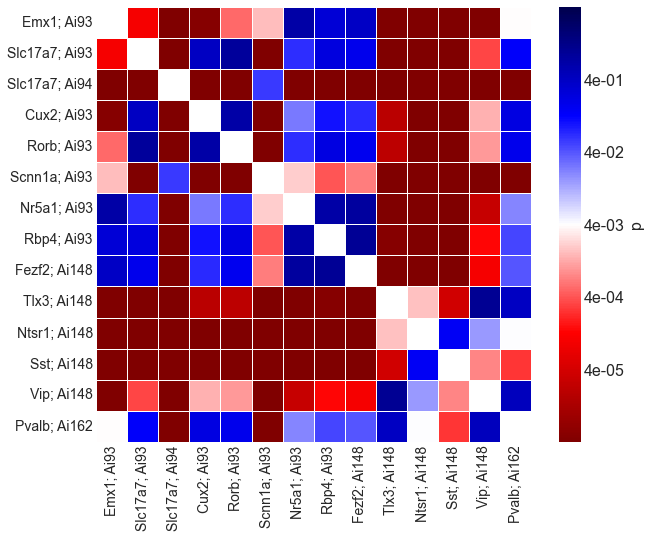

In [15]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(15, 8), facecolor="white")
    bottom = None
    df = cells["sr_label"].groupby(cells[CRE_PLOT_KEY]).value_counts(normalize=True)

    for sr_label, color in SR_LABELS:
        if sr_label == "No response": continue
        heights = []
        for cre in CRE_ORDERING:
            heights.append(df[cre][sr_label] if sr_label in df[cre] else 0)
        ax.bar(CRE_ORDERING, heights, bottom=bottom, label=sr_label, color=color)
        bottom = heights if bottom is None else bottom + np.array(heights)

    ax.legend(fontsize=16, frameon=True, loc="upper left")
    plt.setp(ax.get_xticklabels(), fontsize=18, rotation=90)
    ax.set_xlabel("")
    ax.set_ylim(0, 0.2)
    yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25]
    ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticklabels([f"{tick}%" if int(tick) == tick else None for tick in yticks], fontsize=18)
    ax.set_ylabel("Percent saccade-responsive", fontsize=18)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # for text, cre in zip(ax.get_xticklabels(), CRE_ORDERING):
    #     text.set_bbox(dict(facecolor=match_cre_line(cre).color, alpha=0.5))

    bar_labels = [np.sum(cells[CRE_PLOT_KEY] == cre) for cre in CRE_ORDERING]
    ax.bar_label(ax.containers[-1], labels=bar_labels, fmt="%d", padding=8, fontsize=16, backgroundcolor="w")
    savefig(fig, "fraction_responsive_by_cre.png")

    # Generate probability matrix
    p_matrix = np.zeros((len(CRE_ORDERING), len(CRE_ORDERING)), dtype=float)
    counts = cells.groupby(CRE_PLOT_KEY)["is_sr"].value_counts()

    print(counts.head(4))
            
    for i in range(len(CRE_ORDERING)):
        p_matrix[i,i] = np.nan
        for j in range(i+1, len(CRE_ORDERING)):
            observed = [
                [counts[CRE_ORDERING[i]][True], counts[CRE_ORDERING[i]][False]],
                [counts[CRE_ORDERING[j]][True], counts[CRE_ORDERING[j]][False]]
            ]
            p_val = stats.chi2_contingency(observed)[1]
            p_matrix[i,j] = p_matrix[j,i] = p_val

    fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=CRE_ORDERING, title=f"", figsize=(10, 8))
    savefig(fig, "sr_by_cre_proba.png")

targeted_structure  is_sr
VISal               False    2523
                    True      313
VISam               False    1923
                    True      282
Name: is_sr, dtype: int64


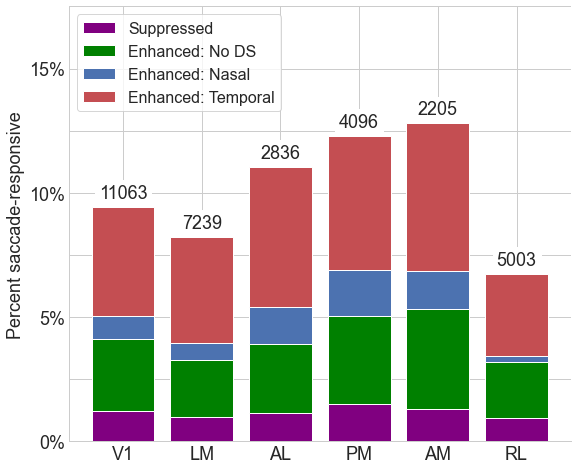

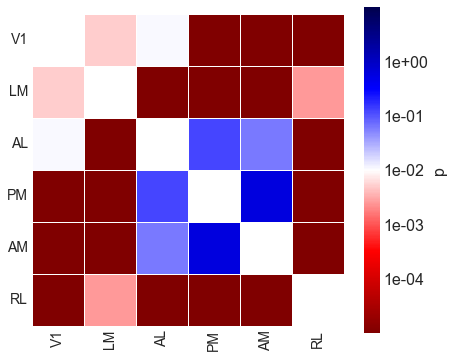

In [16]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(9, 8), facecolor="white")
    bottom = None
    df = cells["sr_label"].groupby(cells["targeted_structure"]).value_counts(normalize=True)
    areas = [AREA_ABBREV[area] for area in AREA_ORDERING]

    for sr_label, color in SR_LABELS:
        if sr_label == "No response": continue
        heights = []
        for area in AREA_ORDERING:
            heights.append(df[area][sr_label] if sr_label in df[area] else 0)
        ax.bar(areas, heights, bottom=bottom, label=sr_label, color=color)
        heights = np.array(heights)
        bottom = heights if bottom is None else bottom + heights

    # ax.bar(agg_tips.index, agg_tips['Female'], bottom=agg_tips['Male'],
    # label='Female')
    # ax.set_title('Tips by Day and Gender')
    ax.legend(fontsize=16, frameon=True, loc="upper left")
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=18)
    ax.set_xlabel("")
    yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
    ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticklabels([f"{tick}%" if int(tick) == tick else None for tick in yticks], fontsize=18)
    ax.set_ylabel("Percent saccade-responsive", fontsize=18)

    bar_labels = [np.sum(cells["targeted_structure"] == area) for area in AREA_ORDERING]
    ax.bar_label(ax.containers[-1], labels=bar_labels, fmt="{}", padding=5, fontsize=18, backgroundcolor="w")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    savefig(fig, "fraction_responsive_by_area.png")

    # Generate probability matrix
    p_matrix = np.zeros((len(AREA_ORDERING), len(AREA_ORDERING)), dtype=float)
    counts = cells.groupby("targeted_structure")["is_sr"].value_counts()

    print(counts.head(4))
            
    for i in range(len(AREA_ORDERING)):
        p_matrix[i,i] = np.nan
        for j in range(i+1, len(AREA_ORDERING)):
            observed = [
                [counts[AREA_ORDERING[i]][True], counts[AREA_ORDERING[i]][False]],
                [counts[AREA_ORDERING[j]][True], counts[AREA_ORDERING[j]][False]]
            ]
            p_val = stats.chi2_contingency(observed)[1]
            p_matrix[i,j] = p_matrix[j,i] = p_val

    fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=areas, title=f"", figsize=(7, 6))
    savefig(fig, "sr_by_area_proba.png")

In [17]:
cells["is_sr"].groupby(cells["targeted_structure"]).value_counts(normalize=False)

targeted_structure  is_sr
VISal               False     2523
                    True       313
VISam               False     1923
                    True       282
VISl                False     6645
                    True       594
VISp                False    10020
                    True      1043
VISpm               False     3593
                    True       503
VISrl               False     4667
                    True       336
Name: is_sr, dtype: int64

# Direction selectivity

SR: -0.01, 0.49, 0.93 (mean = 0.50 ± 1.41)
SR-DS-R: 0.58, 0.84, 1.27 (mean = 1.06 ± 1.56)
SR-DS-L: -1.02, -0.68, -0.39 (mean = -0.88 ± 1.03)


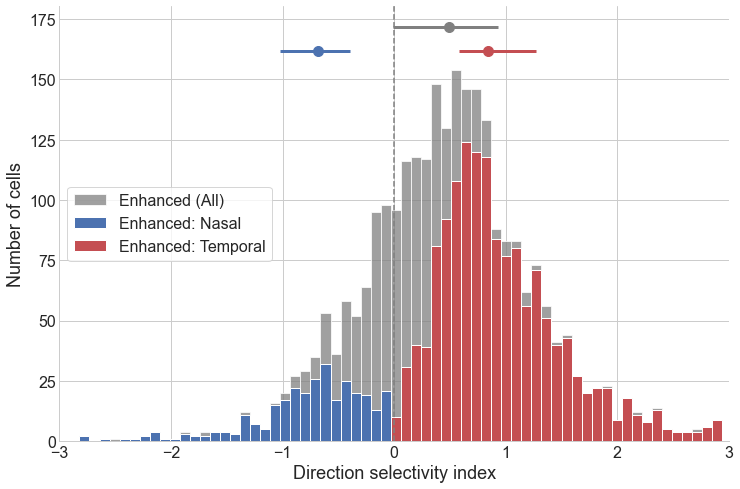

In [18]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")

    is_sr = cells["response_classification"] == 1
    values = cells[is_sr]["direction_selectivity"].dropna().values
    # values = cells["direction_selectivity"].dropna().values # all cells
    p25_sr, p50_sr, p75_sr = np.quantile(values, [0.25, 0.5, 0.75])
    print(f"SR: {p25_sr:.2f}, {p50_sr:.2f}, {p75_sr:.2f} (mean = {values.mean():.2f} ± {values.std():.2f})")
    values = values[(-10 < values) & (values < 10)]
    xlim = -3, 3
    n, bins, _ = ax.hist(values, bins=np.arange(*xlim, 0.09), color="gray", alpha=0.75, label="Enhanced (All)")

    srds_R = cells[is_sr & (cells["is_sr_ds"]) & (cells["preferred_direction"] == 1)]["direction_selectivity"].dropna().values
    srds_L = cells[is_sr & (cells["is_sr_ds"]) & (cells["preferred_direction"] == -1)]["direction_selectivity"].dropna().values
    p25_R, p50_R, p75_R = np.quantile(srds_R, [0.25, 0.5, 0.75])
    p25_L, p50_L, p75_L = np.quantile(srds_L, [0.25, 0.5, 0.75])
    print(f"SR-DS-R: {p25_R:.2f}, {p50_R:.2f}, {p75_R:.2f} (mean = {srds_R.mean():.2f} ± {srds_R.std():.2f})")
    print(f"SR-DS-L: {p25_L:.2f}, {p50_L:.2f}, {p75_L:.2f} (mean = {srds_L.mean():.2f} ± {srds_L.std():.2f})")
    srds_L = srds_L[(-10 < srds_L) & (srds_L < 10)]
    srds_R = srds_R[(-10 < srds_R) & (srds_R < 10)]
    ax.hist(srds_L, bins=bins, alpha=1, color="b", label="Enhanced: Nasal")
    ax.hist(srds_R, bins=bins, alpha=1, color="r", label="Enhanced: Temporal")

    ax.set_xlim(*xlim)
    y = ax.get_ylim()[1]

    ax.scatter(p50_sr, y+10, color="gray", s=100, zorder=10)
    ax.hlines(xmin=p25_sr, xmax=p75_sr, y=y+10, color="gray", linewidth=3, zorder=10)

    ax.scatter(p50_L, y, color="b", s=100, zorder=10)
    ax.hlines(xmin=p25_L, xmax=p75_L, y=y, color="b", linewidth=3, zorder=10)

    ax.scatter(p50_R, y, color="r", s=100, zorder=10)
    ax.hlines(xmin=p25_R, xmax=p75_R, y=y, color="r", linewidth=3, zorder=10)

    ax.axvline(0, color="gray", linestyle="dashed")

    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    ax.set_xlabel("Direction selectivity index", fontsize=18)
    ax.set_ylabel("Number of cells", fontsize=18)
    ax.legend(fontsize=16, loc="center left", frameon=True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    savefig(fig, "direction_selectivity.png")

    # ax.set_title("Direction selectivity")

mean no pref N/T: 0.0249, 0.0302
mean nasal N/T: 0.0528, 0.0074
mean temporal N/T: 0.0015, 0.0490
n_sr_enhanced: 2696
no_pref: 911
nasal: 318
temporal: 1467


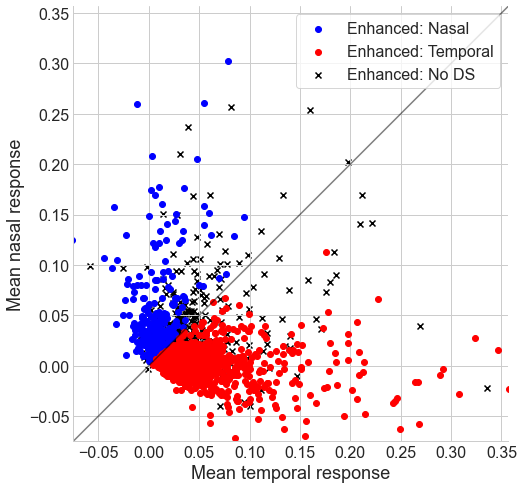

In [19]:
def plot_yeqx(ax, **kwargs):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, zorder=1, **kwargs)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 8), facecolor="white")
    x = cells["mean_right_response"].values
    y = cells["mean_left_response"].values

    is_sr = cells["response_classification"] == 1
    n_sr = is_sr.sum()
    no_pref = is_sr & ~(cells["is_sr_ds"])
    nasal = is_sr & (cells["preferred_direction"] == -1)
    nasal_suppressed = is_sr & (cells["preferred_direction"] == -1)
    temporal = is_sr & (cells["preferred_direction"] == 1)

    ax.scatter(x[nasal], y[nasal], color="blue", label=f"Enhanced: Nasal") # ({nasal.sum()/n_sr*100:.1f}%)
    ax.scatter(x[temporal], y[temporal], color="red", label=f"Enhanced: Temporal") # ({temporal.sum()/n_sr*100:.1f}%)
    ax.scatter(x[no_pref], y[no_pref], color="black", marker="x", label=f"Enhanced: No DS", zorder=0) # ({no_pref.sum()/n_sr*100:.1f}%)

    print(f"mean no pref N/T: {y[no_pref].mean():.4f}, {x[no_pref].mean():.4f}")
    print(f"mean nasal N/T: {y[nasal].mean():.4f}, {x[nasal].mean():.4f}")
    print(f"mean temporal N/T: {y[temporal].mean():.4f}, {x[temporal].mean():.4f}")

    ax.set_xlabel("Mean temporal response", fontsize=18)
    ax.set_ylabel("Mean nasal response", fontsize=18)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    print(f"n_sr_enhanced: {n_sr}")
    print(f"no_pref: {no_pref.sum()}")
    print(f"nasal: {nasal.sum()}")
    print(f"temporal: {temporal.sum()}")

    ax.legend(loc="upper right", fontsize=16, frameon=True)
    ax.set_xlim(-0.075, np.quantile(x[cells["is_sr"]], [0.995]))
    ax.set_ylim(-0.075, np.quantile(y[cells["is_sr"]], [0.995]))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plot_yeqx(ax, color="black", alpha=0.5)
    savefig(fig, "direction_selectivity_scatter.png")

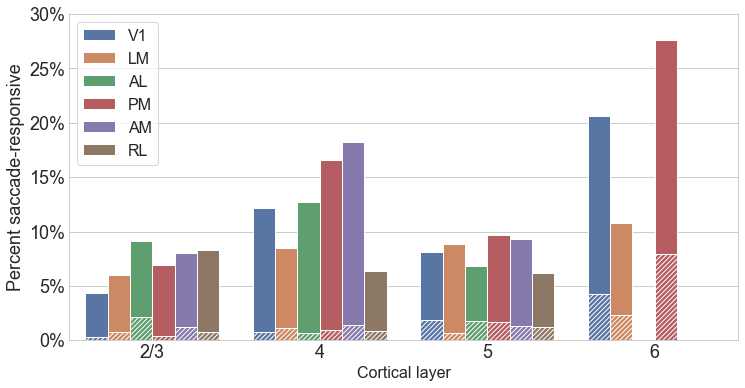

In [20]:
order = sorted(cells["cortical_layer"].unique())

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")
    bar = sns.barplot(data=cells, x="cortical_layer", ci=None, y="is_sr", hue="targeted_structure", ax=ax, order=order, hue_order=AREA_ORDERING)
    patches1 = bar.patches[:]

    legend_handles = ax.legend_.legendHandles
    bar2 = sns.barplot(x=cells["cortical_layer"], ci=None, y=(cells["response_classification"] == -1), hue=cells["targeted_structure"], ax=ax, order=order, hue_order=AREA_ORDERING)

    for patch in bar2.patches:
        if patch not in patches1:
            patch.set_hatch("/////")

    # ax.set_title("SUPPRESSED", fontsize=16)
    ax.set_xlabel("Cortical layer", fontsize=16)
    ax.set_ylabel("Percent saccade-responsive", fontsize=18)
    ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
    ax.set_ylim(min(ax.get_yticks()), max(ax.get_yticks()))
    ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ax.get_yticks()])
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=18)
    ax.legend(handles=legend_handles, labels=[AREA_ABBREV[area] for area in ax.get_legend_handles_labels()[1]], fontsize=16, frameon=True)
    savefig(fig, "frac_responsive_by_layer_across_areas.png")

/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


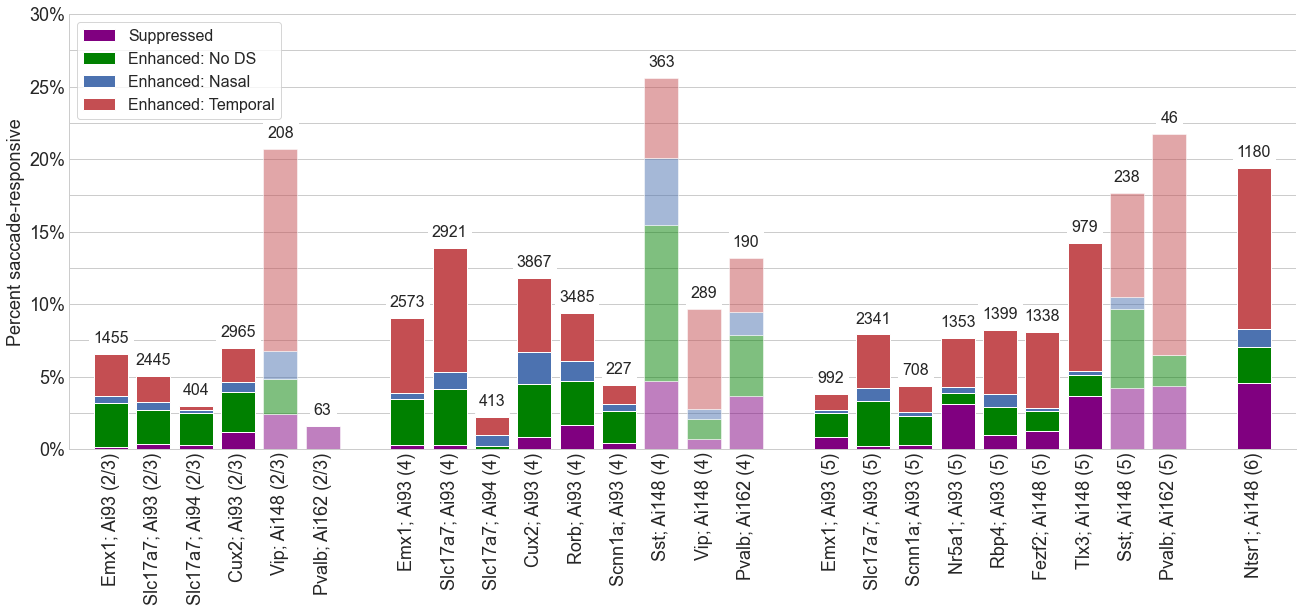

In [21]:
cre_and_layer = []
all_layers = sorted(cells["cortical_layer"].unique())
tick_labels_unique = []
tick_labels = []
bar_labels = []

for i, layer in enumerate(all_layers):
    for cre in CRE_ORDERING:
        mask = (cells[CRE_PLOT_KEY] == cre) & (cells["cortical_layer"] == layer)
        n_cells = mask.sum()
        if n_cells > 0:
            cre_and_layer.append((cre, layer))
            tick_labels.append(f"{cre} ({layer})")
            # bar_labels.append(f"{(mask & (cells['is_sr'])).sum()}/{n_cells}")
            bar_labels.append(f"{n_cells}")

    if i < len(all_layers) - 1:
        cre_and_layer.append((None, None))
        tick_labels.append("")
        bar_labels.append("")

tick_labels_unique = [str(i) for i in range(len(tick_labels))]

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(22, 8), facecolor="white")
    bottom = None
    df = cells.groupby(by=[CRE_PLOT_KEY, "cortical_layer"])["sr_label"].value_counts(normalize=True)

    for sr_label, color in SR_LABELS:
            if sr_label == "No response": continue
            heights = []
            excitatory = []

            for cre, layer in cre_and_layer:
                if layer == None:
                    heights.append(0)
                    is_excitatory = True
                else:
                    heights.append(df[cre][layer][sr_label] if sr_label in df[cre][layer] else 0)
                    cre_line = match_cre_line(cre)
                    is_excitatory = cre_line.is_excitatory

                excitatory.append(is_excitatory)

            bar_container = ax.bar(tick_labels_unique, heights, bottom=bottom, label=sr_label, color=color)

            for patch, is_excitatory in zip(bar_container.patches, excitatory):
                if not is_excitatory:
                    # patch.set_hatch("ooo")
                    patch.set_alpha(0.5)

            bottom = heights if bottom is None else bottom + np.array(heights)

    ax.legend(fontsize=16, frameon=True, loc="upper left")
    ax.set_xticklabels(tick_labels, fontsize=18, rotation=90)
    # plt.setp(ax.get_xticklabels(), )
    ax.set_xlabel("")
    ax.set_ylim(0, 0.2)
    yticks = np.arange(0, 31, 2.5)
    ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticklabels([f"{tick:.0f}%" if int(tick) == tick else None for tick in yticks], fontsize=18)
    ax.set_ylabel("Percent saccade-responsive", fontsize=18)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)    
    ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=16, backgroundcolor="w")
    ax.xaxis.grid(False) # Remove vertical grid lines
    ax.set_xlim(-1, len(tick_labels))
    savefig(fig, "frac_responsive_by_cre_and_layer.png")

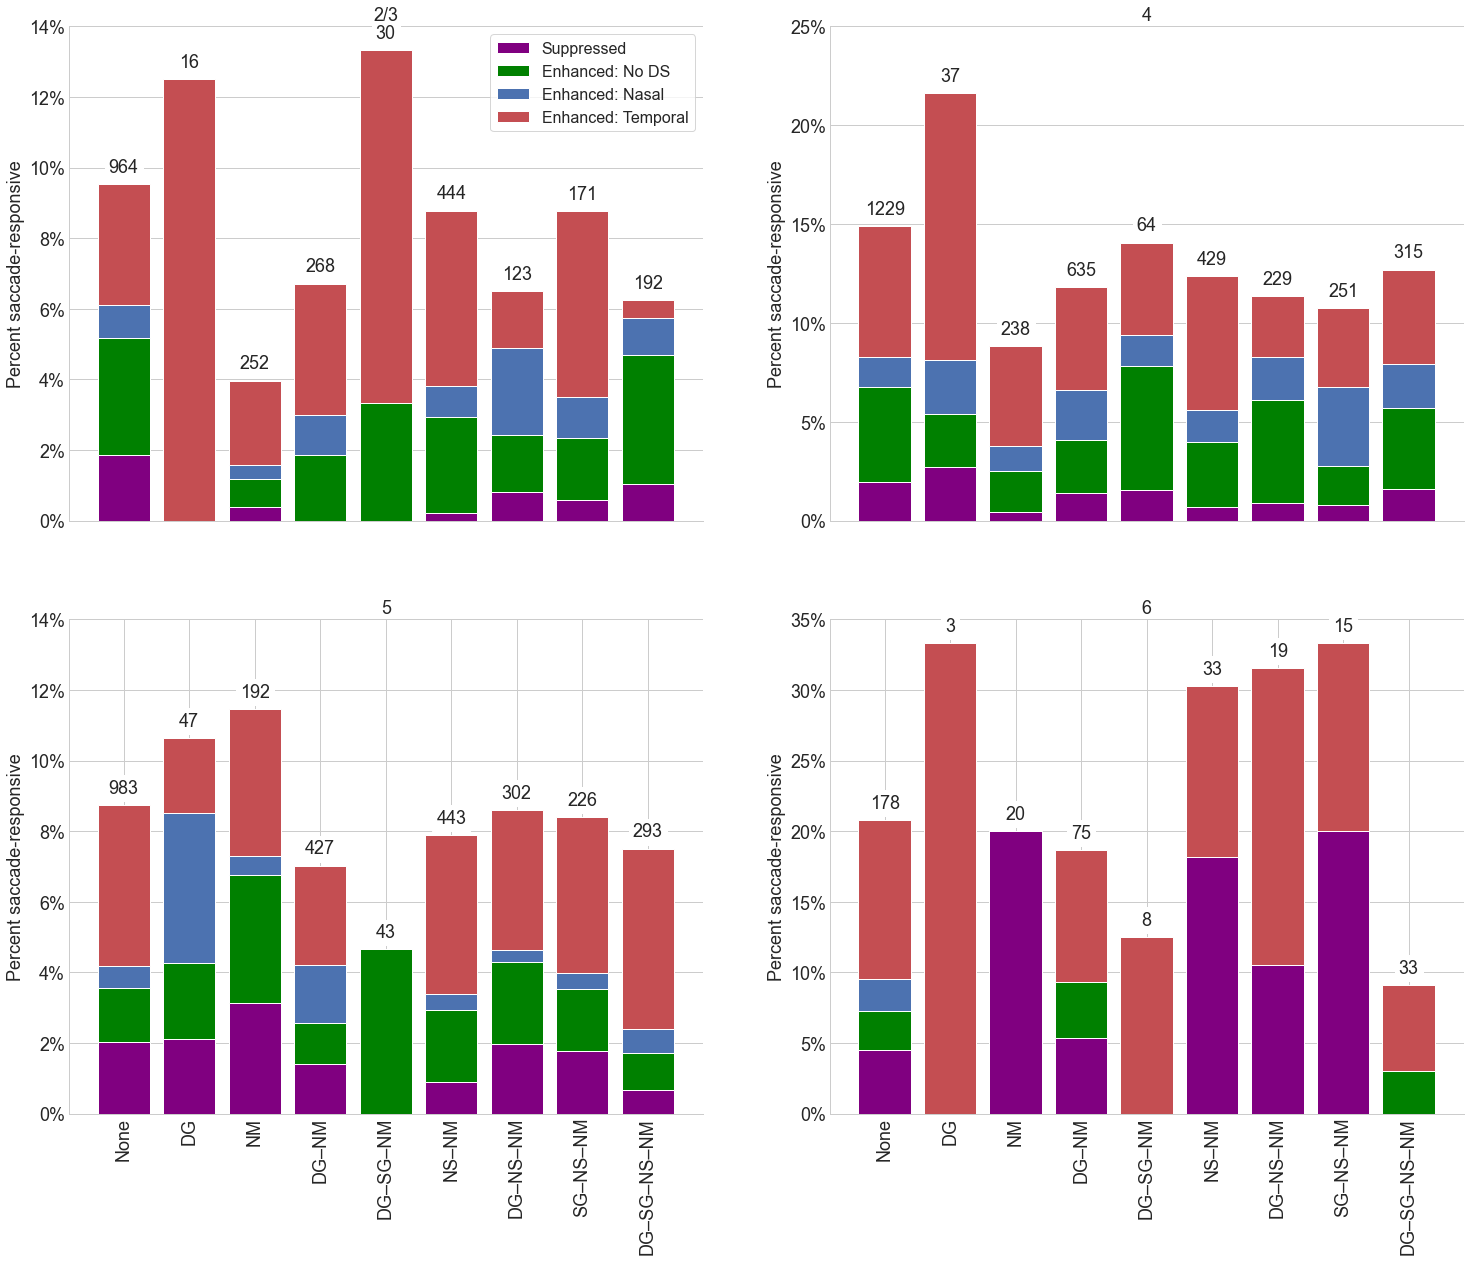

In [22]:
cluster_ids = [int(x) for x in cells_and_metrics["cluster_id"].dropna().unique()]
cluster_ids.sort()
cluster_id_to_label = [
    "None", "DG", "SG", "DG-SG", "NS", "DG-NS", "SG-NS", "DG-SG-NS",
    "NM", "DG-NM", "SG-NM", "DG-SG-NM", "NS-NM", "DG-NS-NM", "SG-NS-NM", "DG-SG-NS-NM"
]
cluster_id_to_label = [x.replace("-", "–") for x in cluster_id_to_label] # slightly longer dash
cluster_id_labels = [f"{cluster_id_to_label[x]}" for x in cluster_ids]

with plt.style.context("seaborn-whitegrid"):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25, 20), facecolor="white")
    axs = axs.flatten()

    for i, layer in enumerate(sorted(cells_and_metrics["cortical_layer"].dropna().unique())):
        # fig, ax = plt.subplots(figsize=(15, 8), facecolor="white")
        ax = axs[i]
        bottom = None
        df = cells_and_metrics[cells_and_metrics["cortical_layer"] == layer].groupby("cluster_id")["sr_label"].value_counts(normalize=True)
        areas = [AREA_ABBREV[area] for area in AREA_ORDERING]

        for sr_label, color in SR_LABELS:
            if sr_label == "No response": continue
            heights = []
            for cluster_id in cluster_ids:
                heights.append(df[cluster_id][sr_label] if sr_label in df[cluster_id] else 0)
            ax.bar(cluster_id_labels, heights, bottom=bottom, label=sr_label, color=color)
            bottom = heights if bottom is None else bottom + np.array(heights)

        if i == 0:
            ax.legend(fontsize=16, frameon=True)
        plt.setp(ax.get_xticklabels(), fontsize=18, rotation=90)
        plt.setp(ax.get_yticklabels(), fontsize=18)
        ax.set_xlabel("")
        # yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
        # ax.set_yticks([tick/100 for tick in yticks])
        ax.set_yticks(ax.get_yticks())
        yticks = ax.get_yticks()
        ax.set_yticklabels([f"{tick*100:.0f}%" for tick in yticks], fontsize=18)
        ax.set_ylabel("Percent saccade-responsive", fontsize=18)

        if i < 2:
            ax.set_xticks([])

        # bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum()}\n({(cells_and_metrics['cluster_id'] == cluster_id).sum()})" for cluster_id in cluster_ids]
        # bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum()}/{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in cluster_ids]
        bar_labels = [f"{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in cluster_ids]
        bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['cortical_layer'] == layer)).sum()}" for cluster_id in cluster_ids]
        ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=18, backgroundcolor="w")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_title(layer, fontsize=18)
    # savefig(fig, "cluster_ids.png")

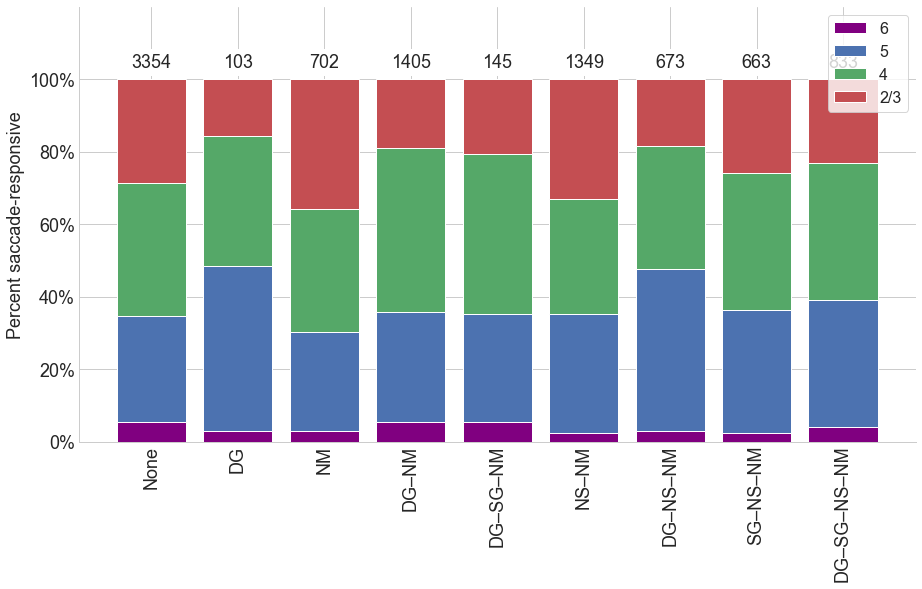

In [23]:
cluster_ids = [int(x) for x in cells_and_metrics["cluster_id"].dropna().unique()]
cluster_ids.sort()
cluster_id_to_label = [
    "None", "DG", "SG", "DG-SG", "NS", "DG-NS", "SG-NS", "DG-SG-NS",
    "NM", "DG-NM", "SG-NM", "DG-SG-NM", "NS-NM", "DG-NS-NM", "SG-NS-NM", "DG-SG-NS-NM"
]
cluster_id_to_label = [x.replace("-", "–") for x in cluster_id_to_label] # slightly longer dash
cluster_id_labels = [f"{cluster_id_to_label[x]}" for x in cluster_ids]

layer_and_color = [
    ("2/3", "r"),
    ("4", "g"),
    ("5", "b"),
    ("6", "purple")
]

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(15, 8), facecolor="white")
    bottom = None
    df = cells_and_metrics.groupby("cluster_id")["cortical_layer"].value_counts(normalize=True)
    areas = [AREA_ABBREV[area] for area in AREA_ORDERING]

    for layer, color in reversed(layer_and_color):
        heights = []
        for cluster_id in cluster_ids:
            heights.append(df[cluster_id][layer] if layer in df[cluster_id] else 0)
        ax.bar(cluster_id_labels, heights, bottom=bottom, label=layer, color=color)
        bottom = heights if bottom is None else bottom + np.array(heights)

    ax.legend(fontsize=16, frameon=True)
    plt.setp(ax.get_xticklabels(), fontsize=18, rotation=90)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    ax.set_xlabel("")
    # yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
    # ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticks(ax.get_yticks())
    yticks = [0, .2 , .4, .6, .8, 1]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{tick*100:.0f}%" for tick in yticks], fontsize=18)
    ax.set_ylabel("Percent saccade-responsive", fontsize=18)

    if i < 2:
        ax.set_xticks([])

    # bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum()}\n({(cells_and_metrics['cluster_id'] == cluster_id).sum()})" for cluster_id in cluster_ids]
    # bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum()}/{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in cluster_ids]
    bar_labels = [f"{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in cluster_ids]
    ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=18, backgroundcolor="w")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # savefig(fig, "cluster_ids.png")

In [24]:
cells_and_metrics.groupby("cluster_id")["sr_label"].value_counts(normalize=True)

cluster_id  sr_label          
0.0         No response           0.881336
            Enhanced: Temporal    0.053369
            Enhanced: No DS       0.033095
            Suppressed            0.020871
            Enhanced: Nasal       0.011330
1.0         No response           0.844660
            Enhanced: Temporal    0.087379
            Enhanced: Nasal       0.029126
            Enhanced: No DS       0.019417
            Suppressed            0.019417
8.0         No response           0.918803
            Enhanced: Temporal    0.037037
            Enhanced: No DS       0.019943
            Suppressed            0.017094
            Enhanced: Nasal       0.007123
9.0         No response           0.902491
            Enhanced: Temporal    0.044128
            Enhanced: No DS       0.021352
            Enhanced: Nasal       0.018505
            Suppressed            0.013523
11.0        No response           0.889655
            Enhanced: No DS       0.048276
            Enhanced: T

cluster_id  is_sr
0.0         False    2956
            True      398
1.0         False      87
            True       16
Name: is_sr, dtype: int64


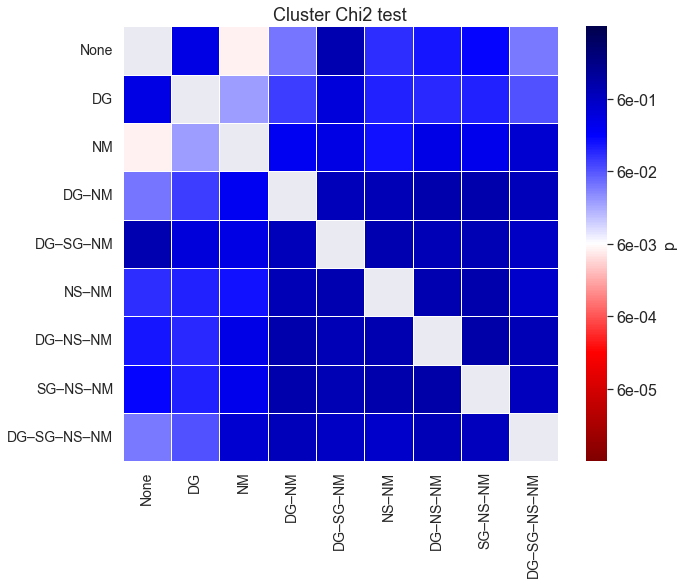

In [25]:
p_matrix = np.zeros((len(cluster_ids), len(cluster_ids)), dtype=float)
counts = cells_and_metrics.groupby("cluster_id")["is_sr"].value_counts()

print(counts.head(4))
        
for i in range(len(cluster_ids)):
    p_matrix[i,i] = np.nan
    for j in range(i+1, len(cluster_ids)):
        observed = [
            [counts[cluster_ids[i]][True], counts[cluster_ids[i]][False]],
            [counts[cluster_ids[j]][True], counts[cluster_ids[j]][False]]
        ]
        p_val = stats.chi2_contingency(observed)[1]
        p_matrix[i,j] = p_matrix[j,i] = p_val

fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=cluster_id_labels, title=f"Cluster Chi2 test", figsize=(10, 8))
savefig(fig, "cluster_ids_proba.png")

In [26]:
print(f"{(cells_and_metrics['responsive_dg'] == True).sum():,} out of {len(cells):,} cells in our dataset were responsive to drifting gratings.")
print(f"{(cells_and_metrics['responsive_ns'] == True).sum():,} out of {len(cells):,} cells in our dataset were responsive to natural scenes.")

10,956 out of 32,442 cells in our dataset were responsive to drifting gratings.
7,744 out of 32,442 cells in our dataset were responsive to natural scenes.


In [27]:
cells.loc[662209107]["session_indices"]

'((627823695, 2), (629789161, 6), (636889229, 5))'

[DSI_pref_tf] No response vs. No DS: p = 0.0113
[DSI_pref_tf] No response vs. Nasal: p = 0.9407
[DSI_pref_tf] No response vs. Temporal: p = 0.1161
[DSI_pref_tf] No DS vs. Nasal: p = 0.1315
[DSI_pref_tf] No DS vs. Temporal: p = 0.0553
[DSI_pref_tf] Nasal vs. Temporal: p = 0.8468
[g_osi_dg] No response vs. No DS: p = 0.3038
[g_osi_dg] No response vs. Nasal: p = 0.0023
[g_osi_dg] No response vs. Temporal: p = 0.1217
[g_osi_dg] No DS vs. Nasal: p = 0.0764
[g_osi_dg] No DS vs. Temporal: p = 0.7450
[g_osi_dg] Nasal vs. Temporal: p = 0.0684
[lifetime_sparseness_ns] No response vs. No DS: p = 0.5708
[lifetime_sparseness_ns] No response vs. Nasal: p = 0.0028
[lifetime_sparseness_ns] No response vs. Temporal: p = 0.0611
[lifetime_sparseness_ns] No DS vs. Nasal: p = 0.0206
[lifetime_sparseness_ns] No DS vs. Temporal: p = 0.5309
[lifetime_sparseness_ns] Nasal vs. Temporal: p = 0.0136


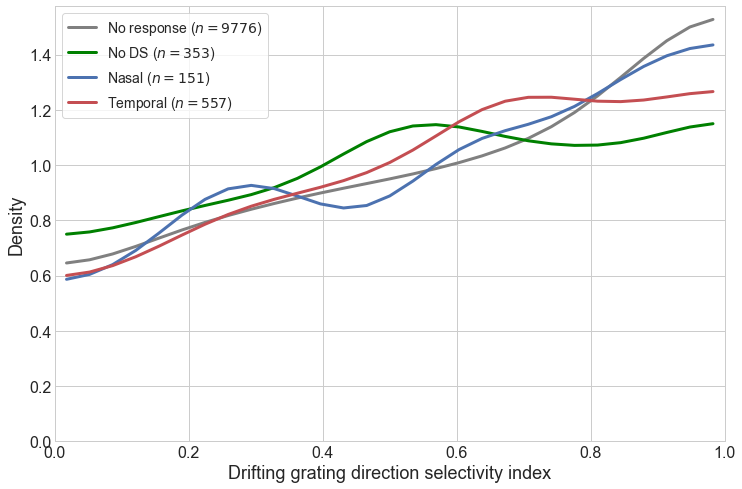

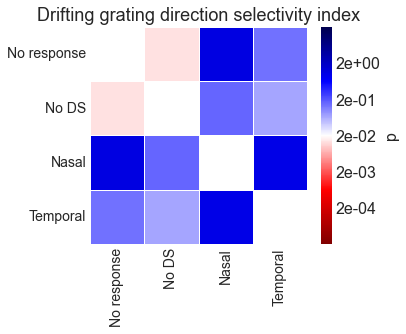

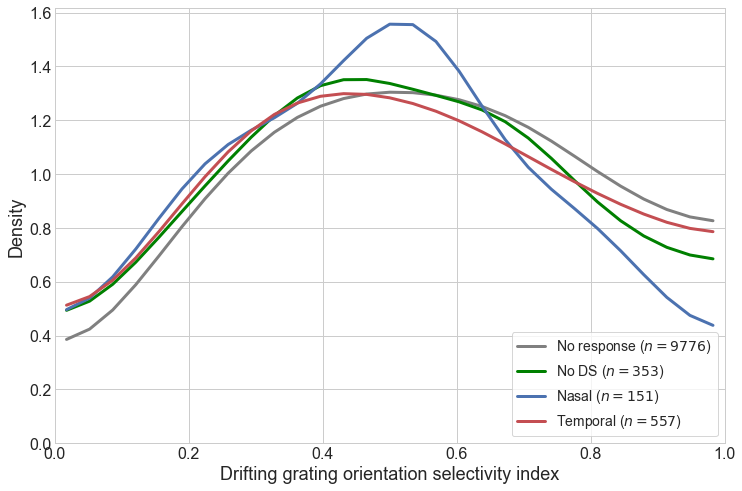

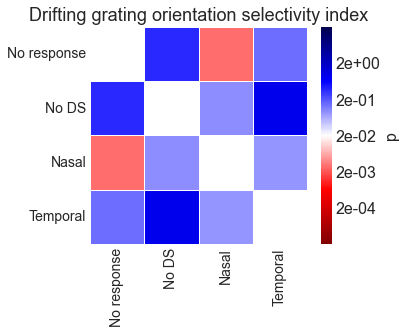

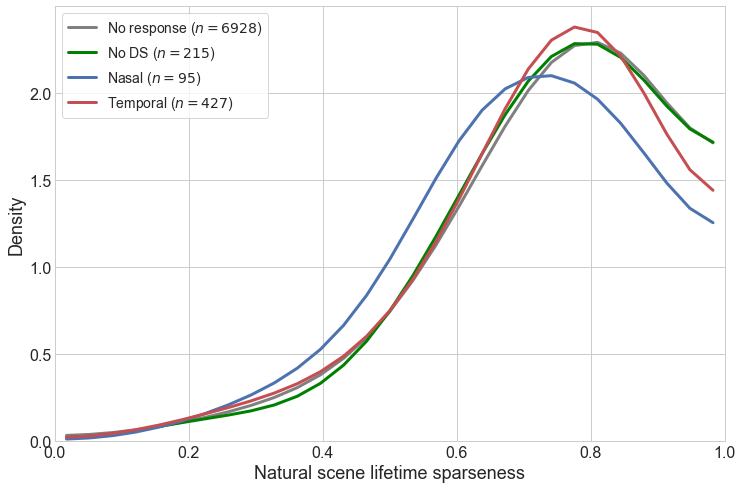

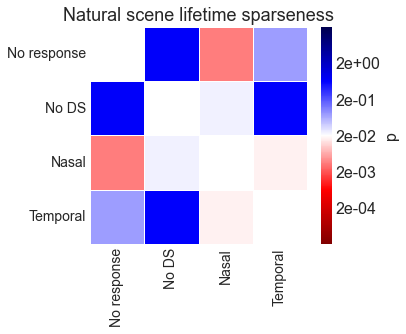

In [28]:
with plt.style.context("seaborn-whitegrid"):
    for metric, response_metric, plot_label in [
        ("DSI_pref_tf", "responsive_dg", "Drifting grating direction selectivity index"),
        # ("g_dsi_dg", "responsive_dg", "Drifting grating direction selectivity index"),
        ("g_osi_dg", "responsive_dg", "Drifting grating orientation selectivity index"),
        ("lifetime_sparseness_ns", "responsive_ns", "Natural scene lifetime sparseness")
        # ("image_selectivity_ns", "responsive_ns", "Image selectivity")
    ]:
        if response_metric is not None:
            has_response = (cells_and_metrics[response_metric] == True)
        else:
            has_response = ~cells_and_metrics[metric].isna()
        
        sr_ds_nasal = cells_and_metrics[metric].values[has_response & (cells_and_metrics["is_sr_ds"]) & (cells_and_metrics["preferred_direction"] == -1)]
        sr_ds_temporal = cells_and_metrics[metric].values[has_response & (cells_and_metrics["is_sr_ds"]) & (cells_and_metrics["preferred_direction"] == 1)]
        sr_not_ds = cells_and_metrics[metric].values[has_response & (cells_and_metrics["is_sr"]) & ~(cells_and_metrics["is_sr_ds"])]
        not_sr = cells_and_metrics[metric].values[has_response & ~(cells_and_metrics["is_sr"])]

        fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")

        bins = np.linspace(0, 1, 30)
        bin_midpoints = (bins[1:] + bins[:-1]) / 2
        filter_window = 3

        dist_and_label = []

        for label, color in SR_LABELS:
            if "Suppressed" in label: continue # Too few suppressed cells to draw meaningful conclusions
            dist = cells_and_metrics[metric].values[has_response & (cells_and_metrics["sr_label"] == label)]
            if label.startswith("Enhanced: "): label = label.replace("Enhanced: ", "")
            dist_and_label.append((dist, label))
            hist, _ = np.histogram(dist, bins=bins, density=True)
            smoothed_curve = ndi.gaussian_filter1d(hist, filter_window)
            # ax.bar(bins[:-1], ndi.gaussian_filter1d(h, filter_window), width=np.mean(np.diff(bins)), color=color, alpha=0.2, lw=0)
            ax.plot(bin_midpoints, smoothed_curve, color=color, linewidth=3, label=f"{label} ($n = {len(dist)}$)")

        ax.legend(fontsize=14, frameon=True)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, ax.get_ylim()[1])
        plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
        ax.set_xlabel(plot_label, fontsize=18)
        ax.set_ylabel("Density", fontsize=18)
        # ax.set_title(f"{has_response.sum():d} cells are responsive ({response_metric})", fontsize=16)
        savefig(fig, f"metric_{metric}.png")


        
        p_matrix = np.zeros((len(dist_and_label), len(dist_and_label)), dtype=float)
        
        for i in range(len(dist_and_label)):
            p_matrix[i,i] = np.nan
            for j in range(i+1, len(dist_and_label)):
                a, b = dist_and_label[i][0], dist_and_label[j][0]
                # p_val = stats.ttest_ind(a, b)[1]
                p_val = stats.kstest(a, b)[1]
                p_matrix[i,j] = p_matrix[j,i] = p_val
                print(f"[{metric}] {dist_and_label[i][1]} vs. {dist_and_label[j][1]}: p = {p_val:.4f}")

        fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=[x[1] for x in dist_and_label], title=f"{plot_label}", figsize=(5, 4))
        savefig(fig, f"metric_{metric}_proba.png")

[pref_ori_dg] No response vs. No DS: p = 0.1356
[pref_ori_dg] No response vs. Nasal: p = 0.9261
[pref_ori_dg] No response vs. Temporal: p = 0.0344
[pref_ori_dg] No DS vs. Nasal: p = 0.2076
[pref_ori_dg] No DS vs. Temporal: p = 0.8813
[pref_ori_dg] Nasal vs. Temporal: p = 0.1638


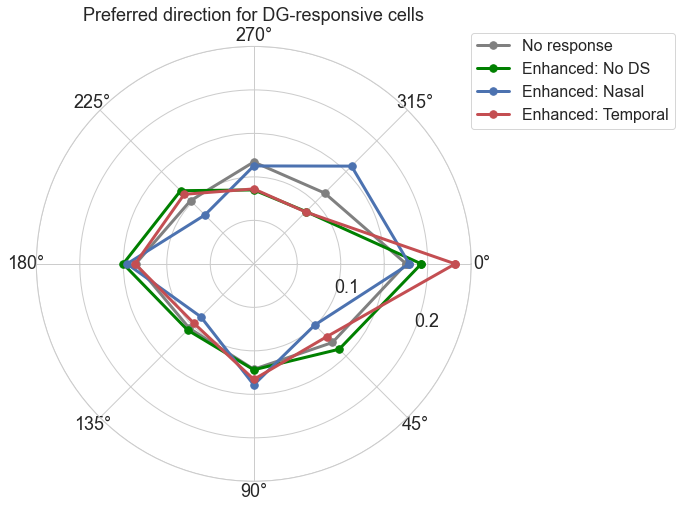

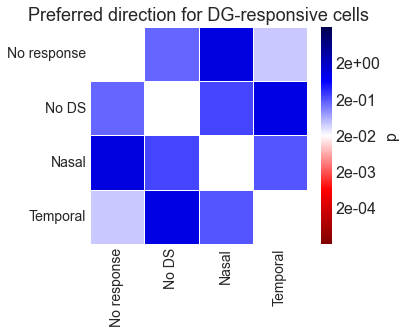

In [29]:
metric = "pref_ori_dg" # called preferred orientation but actually refers to direction of motion
df = cells_and_metrics[metric][cells_and_metrics["responsive_dg"] == True].dropna().groupby(cells_and_metrics["sr_label"]).value_counts(normalize=True).rename("fraction")
angles = sorted(cells_and_metrics["pref_ori_dg"].dropna().unique()) + [360.0]
r = np.arange(0, 2, 0.05)
theta = 2 * np.pi * r

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 8), facecolor="white", subplot_kw=dict(projection="polar"))
    ax.set_theta_direction(-1)
    dist_and_label = []

    for sr_label, color in SR_LABELS:
        if "Suppressed" in sr_label: continue
        r = [df[sr_label][0 if angle == 360 else angle] for angle in angles]
        ax.plot(np.radians(angles), r, color=color, marker=".", markersize=15, linewidth=3, label=sr_label)

        dist = cells_and_metrics[metric][(cells_and_metrics["responsive_dg"] == True) & (cells_and_metrics["sr_label"] == sr_label)].dropna()
        dist_and_label.append((dist, sr_label.replace("Enhanced: ", "")))

    ax.set_rmax(0.25)
    ax.set_rticks([0.05, 0.10, 0.15, 0.20, 0.25])  # Less radial ticks
    ax.set_yticklabels([None, 0.10, None, 0.20, None])  # Less radial ticks
    ax.set_rlabel_position(22.5)  # Move radial labels away from plotted line
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=18)
    ax.grid(True)
    ax.set_title("Preferred direction for DG-responsive cells", fontsize=18)
    ax.legend(frameon=True, fontsize=16, loc="upper left", bbox_to_anchor=(0.98, 1.05))
    savefig(fig, "metric_pref_direction_dg_polar.png")

    p_matrix = np.zeros((len(dist_and_label), len(dist_and_label)), dtype=float)
        
    for i in range(len(dist_and_label)):
        p_matrix[i,i] = np.nan
        for j in range(i+1, len(dist_and_label)):
            a, b = dist_and_label[i][0], dist_and_label[j][0]
            # p_val = stats.ttest_ind(a, b)[1]
            p_val = stats.kstest(a, b)[1]
            p_matrix[i,j] = p_matrix[j,i] = p_val
            print(f"[{metric}] {dist_and_label[i][1]} vs. {dist_and_label[j][1]}: p = {p_val:.4f}")

    fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=[x[1] for x in dist_and_label], title="Preferred direction for DG-responsive cells", figsize=(5, 4))
    savefig(fig, f"metric_pref_direction_dg_proba.png")

    # fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")
    # sns.barplot(data=df.reset_index(), x=metric, y="fraction", hue="sr_label", palette={k: v for (k,v) in SR_LABELS}, hue_order=[x[0] for x in SR_LABELS])
    # ax.set_xticklabels([f"{float(x.get_text()):.0f}°" for x in ax.get_xticklabels()], fontsize=18)
    # plt.setp(ax.get_yticklabels(), fontsize=16)
    # ax.set_xlabel("")
    # ax.set_ylabel("Density", fontsize=16)
    # ax.legend(fontsize=16, frameon=True)

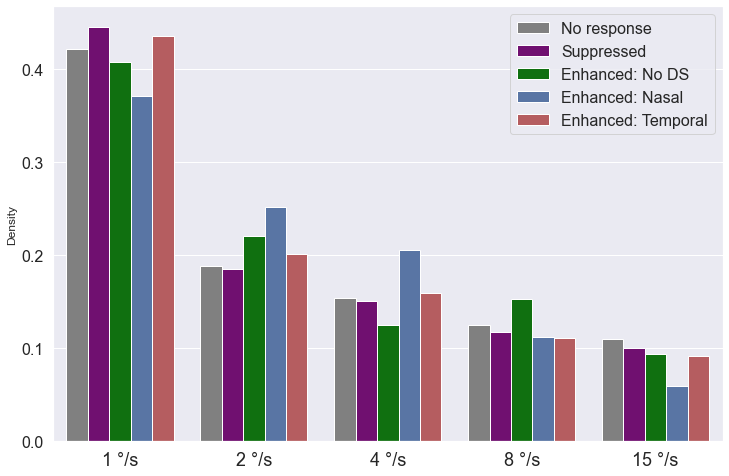

In [30]:
metric = "pref_tf_dg"
df = cells_and_metrics[cells_and_metrics["responsive_dg"] == True][metric].dropna().groupby(cells_and_metrics["sr_label"]).value_counts(normalize=True).rename("fraction").reset_index()

# Get rid of suppressed cells
fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")
sns.barplot(data=df, x=metric, y="fraction", hue="sr_label", palette={k: v for (k,v) in SR_LABELS}, hue_order=[x[0] for x in SR_LABELS])
ax.set_xticklabels([f"{float(x.get_text()):.0f} °/s" for x in ax.get_xticklabels()], fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_xlabel("")
ax.set_ylabel("Density")
ax.legend(fontsize=16, frameon=True)
# TODO: superimposed trace

In [31]:
cells[(cells["targeted_structure"] == "VISrl") & (cells["cortical_layer"] == "2/3")].groupby("cre_line")["response_classification"].value_counts(normalize=True)

cre_line                                           response_classification
Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)        0.0                       0.853896
                                                    1.0                       0.129870
                                                   -1.0                       0.016234
Emx1-IRES-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)       0.0                       0.948949
                                                    1.0                       0.051051
Slc17a7-IRES2-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)   0.0                       0.892308
                                                    1.0                       0.061538
                                                   -1.0                       0.046154
Name: response_classification, dtype: float64

In [32]:
((cells["response_classification"] == 1) & (cells["preferred_direction"] == 0)).sum()

911

In [33]:
cells["preferred_direction"].value_counts()

 0    30657
 1     1467
-1      318
Name: preferred_direction, dtype: int64

In [34]:
cells["response_classification"].value_counts()

 0.0    29371
 1.0     2696
-1.0      375
Name: response_classification, dtype: int64